## Question 1 Cleanup

In [1]:
# import packages
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset
url = 'https://raw.githubusercontent.com/EQWorks/ws-data-pandas/main/data/DataSample.csv'
df = pd.read_csv(url)
df.head() #22025x7

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730


In [3]:
# remove extra space for TimeSt column name
#df.dtypes
df.columns = df.columns.str.replace(' ', '')

In [4]:
# filter out questionable request records
df = df.drop_duplicates(subset = ["TimeSt", "Latitude", "Longitude"]) #dropped 2026 duplicated rows

## Question 2 Label

In [5]:
# Import POI dataset
url2 = 'https://raw.githubusercontent.com/EQWorks/ws-data-pandas/main/data/POIList.csv'
df_poi = pd.read_csv(url2)

# remove extra whitespace in colnames
df_poi.columns = df_poi.columns.str.replace(' ', '')

df_poi

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [6]:
# rename column names
df = df.rename(columns = {'Latitude':'lat','Longitude':'lon'})
df_poi=df_poi.rename(columns = {'Latitude':'lat','Longitude':'lon'})

#### Use Haversine Equation to calculate distance and assign labels.

In [7]:
from math import radians, cos, sin, asin, sqrt

# function calculates distance to POIs
def dist(lat1, long1, lat2, long2): 
    """
    Calculate distance between two points using Haversine Equation. 
    """
    # convert decimal degrees to radians
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    
    # compute haversine formula
    dlon = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    km = 6371*c  #radius of earth is 6371km
    
    return km

# function find the minimum distanced POIID
def find_nearest(lat, long): 
    
    distances = df_poi.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis = 1)
    
    return df_poi.loc[distances.idxmin(), 'POIID']

In [8]:
# append closest POIID to data
df['POIID'] = df.apply(
    lambda row: find_nearest(row['lat'], row['lon']), 
    axis=1)
df

,_ID,TimeSt,Country,Province,City,lat,lon,POIID
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3
...,...,...,...,...,...,...,...,...
22019,5614760,2017-06-21 08:23:01.793,CA,AB,Calgary,51.02093,-114.10621,POI1
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560,POI3
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220,POI3
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260,POI3


## Question 3 Analysis

### 1. Average and Standard Deviation of Distance

In [9]:
# append lat and lon info to data
df = pd.merge(df, df_poi[['POIID', 'lat', 'lon']], on = 'POIID', how = 'left')

# calculate distance between closest POI and each entry in data
df['distance'] = [dist(df.lon_x[i], df.lat_x[i], 
                       df.lon_y[i], df.lat_y[i]) 
                  for i in range(len(df))]
df['distance'] = df['distance'].round(decimals = 3)

In [10]:
# calculate conditional mean and sd
stats = df[['POIID','distance']].groupby('POIID').mean()
stats['std'] = df[['POIID','distance']].groupby('POIID').std()['distance']
stats = stats.rename(columns = {'distance':'mean'})
stats

,mean,std
POIID,,
POI1,301.579842,578.585578
POI3,587.163258,299.748073
POI4,664.043059,2072.764987


We know from glancing at df_poi dataset (or by running duplicated() function) that POI1 and POI2 share the same latitude and longitude (location). In this specific case, we understand that POI would have the same mean and standard deviation as POI1.

However, if the data is of larger size, we could potentially create a new data frame to keep track of duplicated rows (like below).

In [11]:
dup_df = df_poi[df_poi.duplicated(subset=['lat', 'lon'], keep=False)]
dup_df

,POIID,lat,lon
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734


**For this work sample solution, we will assume POI2 is the same as POI1 for the rest of the questions.**

### 2. Radius and Density

In [29]:
# import spatial packages
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

# turn dataset into spaital data frame
geometry = [Point(xy) for xy in zip( df.lon_x, df.lat_x)]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:6267', geometry = geometry) # north america projection

In [30]:
# find the furthest point for each POI (use this as radius)
radius = df.groupby('POIID').max()
radius

,_ID,TimeSt,Country,Province,City,lat_x,lon_x,lat_y,lon_y,distance
POIID,,,,,,,,,,
POI1,5614760,2017-06-21 22:59:56.167,CA,YT,Zhoda,62.8273,-92.60177,53.546167,-113.485734,2624.395
POI3,5615006,2017-06-21 22:59:47.540,CA,QC,York,50.2301,-68.51790,45.521629,-73.566024,2067.552
POI4,5612336,2017-06-21 22:46:29.607,CA,QC,Woodfords,49.1771,-52.65660,45.224830,-63.232729,1183.558


From the calculation, radius that would cover entries for each POI are 14,376 km, 14,376 km, 2,067 km, 12,784 km. 
#### However, these numbers did not pass my gut check since all of data entries appear to be from Canada and the distance from east to west coast canada is only ~5,000 km.  

#### So I took three further steps to examin the data.  
* I double checked unique values in Country and Province columns.  
* I plotted all the data points on a map, overlayed country boundaries. It appears that some values were geocoded in Europe.  
* I inputted lat and lon data from the three rows above and it seems that Zhoda, YT and Woodfords, QC were geocoded to the wrong location.  

array(['CA'], dtype=object)

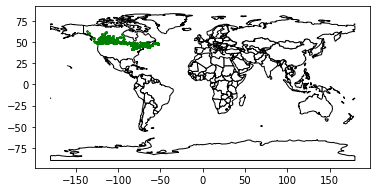

In [31]:
# examine dataset 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = gdf.crs
base = world.plot(color = 'white', edgecolor = 'black')
gdf.plot(ax = base, marker = '*', color = 'green', markersize = 4)
gdf['Country'].unique()

#### For the purpose of this assignment, since I'm unfamiliar with how the data were collected, I decided to drop data entries that were geocoded outside of Canada.   

One simple way to accomplish this is dropping rows with longitude value greater than -25 (a rough estimate based on visualization above).  

#### Realistically, these mistakes can be fixed, sometimes it could be caused by a mistake as simple as messing up the positive/negative sign in lat/lon. 
Another approach I could take is to change all latitude value to positive sign and all longitude value to negative and check whether the city and coordinate aligns well.  

In [32]:
# subset - drop data with wrong geocode
gdf = gdf[gdf['lon_x'] < -25] #22 rows dropped
df = df[df['lon_x'] < -25]

#### Before proceeding, I recalculated average and stadard deviation from 3.1 with this new dataset.

In [33]:
# recalculate conditional mean and sd
stats_new = df[['POIID','distance']].groupby('POIID').mean()
stats_new['std'] = df[['POIID','distance']].groupby('POIID').std()['distance']
stats_new = stats_new.rename(columns = {'distance':'mean'})
stats_new

,mean,std
POIID,,
POI1,291.487914,439.830282
POI3,587.163258,299.748073
POI4,298.586591,315.424777


Now the standard deviation makes a lot more sense. 

#### Back to calculate radius and density. 

In [34]:
# calculate radius
radius_new = df.groupby('POIID').max()
radius_new

,_ID,TimeSt,Country,Province,City,lat_x,lon_x,lat_y,lon_y,distance
POIID,,,,,,,,,,
POI1,5614760,2017-06-21 22:59:56.167,CA,YT,Zhoda,62.8273,-92.60177,53.546167,-113.485734,2624.395
POI3,5615006,2017-06-21 22:59:47.540,CA,QC,York,50.2301,-68.51790,45.521629,-73.566024,2067.552
POI4,5612336,2017-06-21 22:46:29.607,CA,QC,Woodfords,49.1771,-52.65660,45.224830,-63.232729,1183.558


Radius for each POI is as follows:   
* POI1/POI2: 2,624 km
* POI3: 2,068 km
* POI4: 1,184 km

#### Draw circles with radius using buffer.

<AxesSubplot:>

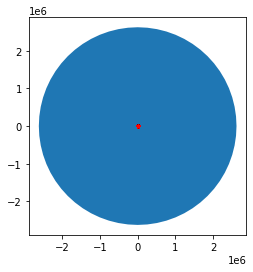

In [35]:
# create spatial dataframe
geometry2 = [Point(xy) for xy in zip( radius_new.lon_y, radius_new.lat_y)]
radius_new = gpd.GeoDataFrame(radius, crs = 'EPSG:6267', geometry = geometry2)
# create buffer column (km -> m)
radius_new['Buffer'] = radius['distance']*1000

# create buffer spatial dataframe
radius_buffer = radius_new.copy()

# for each row, buffer different distance
#radius_buffer['geometry'] = radius_buffer.apply(lambda row: row.geometry.buffer(row.Buffer), axis=1)
radius_buffer['geometry'] = radius_buffer.geometry.buffer(distance=radius_buffer['Buffer'])

# code that should work
temp_plot = radius_buffer.plot()
gdf.plot(ax = temp_plot, marker = '*', color = 'red', markersize = 10)

The above code should work since EPSG 3978 projection intake meter as its buffer unit. For the longest time, I couldn't figure out why the code would show one enlarged circle at (0,0). Upon further examination, I realized that it is because the radius is too big three circles overlap on top of each other. Although I am still not sure at which step in my code I did wrong, the below code works to get the desired map.  




<AxesSubplot:>

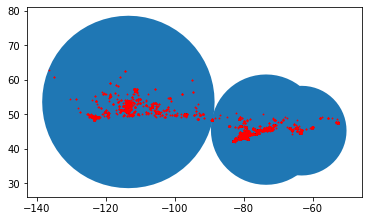

In [36]:
radius_buffer['temp'] = [25.0, 16.0, 13.0]
base = radius_new.buffer(distance = radius_buffer['temp']).plot()
gdf.plot(ax = base, marker = '*', color = 'red', markersize =1)

**Lastly, we need to calculate area and count requests to calculate density in requests/area(km2).**

In [38]:
radius_buffer['area_km2'] = radius_buffer.area/(1000*1000) #in km2
radius_buffer['requests'] = df[['_ID', 'POIID']].groupby(['POIID']).agg('count')
radius_buffer['density'] = radius_buffer['requests']/radius_buffer['area_km2']*10000 #density in requests/10000 km2
radius_buffer['radius_km'] = radius_buffer['distance']

radius_buffer[['radius_km','area_km2', 'requests', 'density']]

,radius_km,area_km2,requests,density
POIID,,,,
POI1,2624.395,2.160282e+07,9720,4.499413
POI3,2067.552,1.340803e+07,9795,7.305325
POI4,1183.558,4.393707e+06,462,1.051504


Request density for each POI are as follows:   
* POI1/POI2: **4** requests per 10,000 km2
* POI3: **7** requests per 10,000 km2
* POI4: **1** requests per 10,000 km2

## Question 4 Data Science/Engineering Tracks

### 4a. model

**Overview:** To build a mathematical model that visualize the popularity of each POI, I've decided to incorporate census data to get a general sense of the demographics at each location on census division (CD) level. I'll calculate number of requests per 100,000 population in each CD as popularity, and normalize this number on a scale of -10 to 10. To give a visual differntiality boost, I'll overlay this choropleth map with original points, color coded by each POI. 

**Import Data & Prepare Data for Analysis**

In [216]:
# import census boundary shapefile
cd_boundary = gpd.read_file('/Users/maggiema/Downloads/lcd_000a16a_e/lcd_000a16a_e.shp') #downloaded from StatsCan
cd_boundary['CDUID']=cd_boundary['CDUID'].astype(int)
cd_boundary.head()

,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,geometry
0,1101,Kings,CTY,11,Prince Edward Island / Île-du-Prince-Édouard,"POLYGON ((8427169.677 1633933.906, 8427164.649..."
1,1102,Queens,CTY,11,Prince Edward Island / Île-du-Prince-Édouard,"POLYGON ((8382758.289 1638763.660, 8382833.617..."
2,1103,Prince,CTY,11,Prince Edward Island / Île-du-Prince-Édouard,"POLYGON ((8294354.734 1636914.940, 8296485.909..."
3,1201,Shelburne,CTY,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((8297919.123 1336571.160, 8298295.283..."
4,1202,Yarmouth,CTY,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((8297919.123 1336571.160, 8297905.200..."


In [217]:
# import population data 
popdat = pd.read_csv('https://raw.githubusercontent.com/mamaggie/SampleWorkSolution/main/pop_data.csv')
popdat.head()

,COL0,COL1
0,1001,270348.0
1,1002,20372.0
2,1003,15560.0
3,1004,20387.0
4,1005,42014.0


In [218]:
# merge data
dat = pd.merge(cd_boundary, popdat, left_on = 'CDUID', right_on = 'COL0', how = 'left')
dat = dat.to_crs('EPSG:4326') #for spatial join
dat.head()

,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,geometry,COL0,COL1
0,1101,Kings,CTY,11,Prince Edward Island / Île-du-Prince-Édouard,"POLYGON ((-62.34662 46.12657, -62.35597 46.113...",1101,17160.0
1,1102,Queens,CTY,11,Prince Edward Island / Île-du-Prince-Édouard,"POLYGON ((-62.82901 46.34050, -62.82865 46.339...",1102,82017.0
2,1103,Prince,CTY,11,Prince Edward Island / Île-du-Prince-Édouard,"POLYGON ((-63.86653 46.66686, -63.84550 46.653...",1103,43730.0
3,1201,Shelburne,CTY,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((-65.39582 44.23232, -65.39249 44.229...",1201,13966.0
4,1202,Yarmouth,CTY,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((-65.39582 44.23232, -65.39669 44.231...",1202,24419.0


<AxesSubplot:>

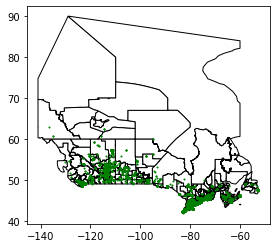

In [219]:
# visualize data
poly = dat.plot(color = 'white', edgecolor = 'black')
gdf.plot(ax = poly, color = 'green', markersize = 1)

**spatial join request data with boundary shapefile and record counts.**

In [220]:
from geopandas.tools import sjoin
# spatial join- assign CDUID to each request entry
join = gpd.sjoin(gdf, dat, how = 'left', op = 'within')
join.head()

,_ID,TimeSt,Country,Province,City,lat_x,lon_x,POIID,lat_y,lon_y,distance,geometry,index_right,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,COL0,COL1
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3,45.521629,-73.566024,771.593,POINT (-80.49109 43.49353),186.0,3530.0,Waterloo,RM,35,Ontario,3530.0,535154.0
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3,45.521629,-73.566024,858.812,POINT (-81.27076 42.93996),193.0,3539.0,Middlesex,CTY,35,Ontario,3539.0,455526.0
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3,45.521629,-73.566024,741.419,POINT (-80.21996 43.57766),180.0,3523.0,Wellington,CTY,35,Ontario,3523.0,222726.0
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3,45.521629,-73.566024,825.638,POINT (-80.97716 43.37166),187.0,3531.0,Perth,CTY,35,Ontario,3531.0,76796.0
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3,45.521629,-73.566024,825.638,POINT (-80.97716 43.37166),187.0,3531.0,Perth,CTY,35,Ontario,3531.0,76796.0


In [221]:
# count number of points in each Census Division
counts = join.groupby('CDUID').size().reset_index(name = 'counts')

# join back with boundary shapefile
dat = pd.merge(dat, counts, on = 'CDUID', how = 'left')
dat['pop'] = dat['COL1']
dat[['CDUID', 'CDNAME', 'pop', 'counts']].head()

,CDUID,CDNAME,pop,counts
0,1101,Kings,17160.0,NaN
1,1102,Queens,82017.0,NaN
2,1103,Prince,43730.0,1.0
3,1201,Shelburne,13966.0,NaN
4,1202,Yarmouth,24419.0,NaN


In [222]:
# turn NaN into 0
dat['counts'] = dat['counts'].fillna(0)

# calculate popularity: counts/pop
dat['popularity'] = dat['counts']/dat['pop']*100000 #per 100,000 people

dat[['CDUID', 'CDNAME', 'pop', 'counts', 'popularity']].head()

,CDUID,CDNAME,pop,counts,popularity
0,1101,Kings,17160.0,0.0,0.00000
1,1102,Queens,82017.0,0.0,0.00000
2,1103,Prince,43730.0,1.0,2.28676
3,1201,Shelburne,13966.0,0.0,0.00000
4,1202,Yarmouth,24419.0,0.0,0.00000


**Examine outliers.**

<AxesSubplot:xlabel='counts'>

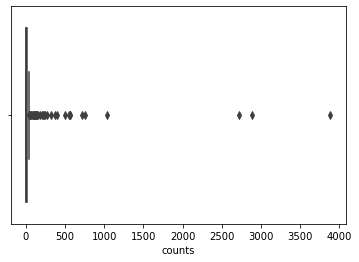

In [223]:
import seaborn as sns
sns.boxplot(x = dat['counts'])

**It seems like a lot of census division has 0 requests. Since we want as much visual differentiation as possible, so we can get rid of the rows/CD now with 0 requests. It will show up on the final map as white background. If overlayed with a basemap, these CDs will be transparent.**

In [224]:
dat = dat[dat.counts > 0]

<AxesSubplot:xlabel='popularity'>

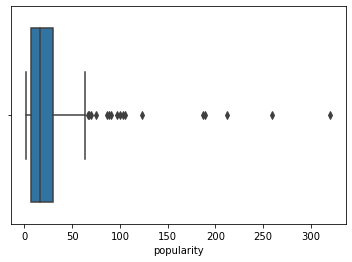

In [225]:
# examine popularity per 100,000 people
sns.boxplot(x = dat['popularity'])

In [226]:
dat[['counts', 'pop', 'popularity']].describe()

,counts,pop,popularity
count,204.000000,2.040000e+02,204.000000
mean,97.823529,1.619157e+05,27.758398
std,404.177640,3.519166e+05,40.442639
min,1.000000,3.319000e+03,1.502630
25%,2.000000,3.134200e+04,6.453644
50%,7.500000,6.051900e+04,16.600729
75%,30.000000,1.213900e+05,30.293501
max,3885.000000,2.731571e+06,320.322214


### Mathematical Model Explanation and Outliers

To normalize popularity to a scale from -10 to 10, I will use 20 divided by the range of popularity values to generate a temporary range from 0-20. Then, I will create a new column with everything 10 point less than the previous column as the final score. 

In an effort to 'be more sensitive around the average and give as much visual differentiability as possible', outliers as shown in boxplot above will be assigned a score of 20. Simlar to method above, I will then divide 19 by the range of the new range of popularity values (who are not an outlier). From this, a score of 1-19 will be generated. Subtract 10 from every value will generate -10 to 10 range. 

In [244]:
# calculate outlier threashold
outlier = np.percentile(dat['popularity'],75) + 1.5*(np.percentile(dat['popularity'],75) - np.percentile(dat['popularity'],25)) #Q3 + 1.5*IQR

# subset non outliers
non_outliers = dat.loc[dat['popularity'] <= outlier]

# calculate score for non-outliers
ratio = 19/(non_outliers['popularity'].max() - non_outliers['popularity'].min())
dat['score'] = dat['popularity']*ratio

# assign score 20 to outliers
dat.loc[dat.popularity > outlier, 'score'] = 20

# adjust to -10 to 10 scale
dat['score_adj'] = dat['score'] - 10

dat['score_adj'].describe()

/Users/maggiema/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/maggiema/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/maggiema/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

count    204.000000
mean      -3.208624
std        5.932240
min       -9.540872
25%       -8.028089
50%       -4.927647
75%       -0.743820
max       10.000000
Name: score_adj, dtype: float64

**And Voila! Here is the final map!**

<AxesSubplot:>

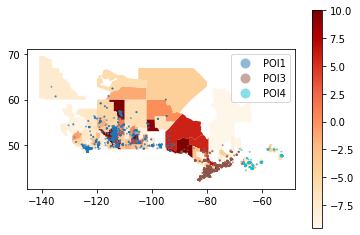

In [249]:
polygon = dat.plot(column = 'score_adj', cmap = 'OrRd', legend = True)
gdf.plot(ax = polygon, column = 'POIID', markersize = 1, alpha = 0.5, legend = True)

* Popularity is measured in number of requests per 100,000 people on census division level.
* 0 popularity is not depicted on map for representing maximum level of differntiability. 
* Census divisions with a large number of requests per population was considered an outlier. They were assigned a score of 10 and these areas can be viewed below:  

In [259]:
dat[dat['score_adj'] == 10] 

,CDUID,CDNAME,geometry,counts,pop,popularity,score,score_adj
75,1307,Westmorland,"POLYGON ((-63.87793 46.05102, -63.89025 46.048...",130.0,149623.0,86.885038,20.0,10.0
92,4711,Division No. 11,"MULTIPOLYGON (((-107.11466 52.39007, -107.1120...",567.0,303423.0,186.867838,20.0,10.0
105,4806,Division No. 6,"POLYGON ((-114.97013 51.88941, -114.95333 51.8...",3885.0,1498778.0,259.211171,20.0,10.0
107,4808,Division No. 8,"POLYGON ((-114.53099 52.88737, -114.52920 52.8...",396.0,209395.0,189.116264,20.0,10.0
108,4809,Division No. 9,"POLYGON ((-116.27615 52.84372, -116.13398 52.8...",22.0,20869.0,105.419522,20.0,10.0
110,4811,Division No. 11,"POLYGON ((-113.69397 53.99268, -113.66971 53.9...",2891.0,1366050.0,211.632078,20.0,10.0
168,3510,Frontenac,"POLYGON ((-76.79163 45.18224, -76.78662 45.171...",146.0,150475.0,97.026084,20.0,10.0
176,3519,York,"POLYGON ((-79.25061 44.45319, -79.25070 44.453...",755.0,1109909.0,68.023595,20.0,10.0
177,3520,Toronto,"POLYGON ((-79.15202 43.81439, -79.15191 43.814...",2719.0,2731571.0,99.539789,20.0,10.0
178,3521,Peel,"POLYGON ((-79.70463 43.86366, -79.70338 43.861...",1039.0,1381739.0,75.195098,20.0,10.0
